In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.metrics import r2_score
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from tqdm import tqdm
import pandas as pd
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
import seaborn as sns

import matplotlib
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

%matplotlib widget

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def compute_point_to_plane_dists(points, plane, signed=False):
#     dists_signed = np.dot(points, plane[:3]) + plane[3] / np.linalg.norm(plane[:3], ord=2)
    dists_signed = (plane[0] * points[:, 0] + plane[1] * points[:, 1] + plane[2] * points[:, 2] + plane[3]) / np.sqrt(np.sum(plane[:3] ** 2))
    return dists_signed if signed else np.abs(dists_signed)

def compute_eig(noise_var, cov):
    return 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(len(cov)))[
        1
    ]

def meshgrid2(*arrs):
    arrs = tuple(reversed(arrs))  #edit
    lens = [len(x) for x in arrs] # map(len, arrs)
    dim = len(arrs)

    sz = 1
    for s in lens:
        sz*=s

    ans = []    
    for i, arr in enumerate(arrs):
        slc = [1]*dim
        slc[i] = lens[i]
        arr2 = np.asarray(arr).reshape(slc)
        for j, sz in enumerate(lens):
            if j!=i:
                arr2 = arr2.repeat(sz, axis=j) 
        ans.append(arr2)

    return tuple(ans)

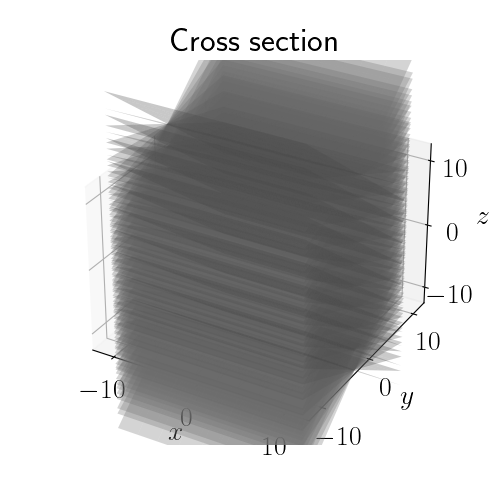

In [3]:


length_scale = 5
noise_variance = 1e-2

xlimits = [-10, 10]
ylimits = [-10, 10]

## Discretize design space (slices / set of planes through the tissue)
grid_size = 10
lims = [-40, 40]


x1s = np.linspace(*xlimits, num=grid_size)
x2s = np.linspace(*ylimits, num=grid_size)
x3s = np.linspace(*ylimits, num=grid_size)
X1, X2, X3 = np.meshgrid(x1s, x2s, x3s)
X = np.vstack([X1.ravel(), X2.ravel(), X3.ravel()]).T
X += np.random.uniform(low=-1, high=1, size=X.shape)

# Warp coordinates with GP
#     X1 = mvn.rvs(mean=X[:, 0], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
#     X2 = mvn.rvs(mean=X[:, 1], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
#     X3 = mvn.rvs(mean=X[:, 2], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
#     X = np.vstack([X1, X2, X3]).T

# Generate response
Y_full = mvn.rvs(mean=np.zeros(X.shape[0]), cov=RBF(length_scale=length_scale)(X) + noise_variance * np.eye(len(X)))

coords = X.copy()
outcome = Y_full.copy()


num_experimental_iters = 5

## Discretize design space (slices / set of planes through the tissue)
# grid_size = 5
lims = [-40, 40]
# n_discretizations = 5
grid_size = 10
n_discretizations = 13
out = meshgrid2(
    np.linspace(xlimits[0] - 5, xlimits[1] + 5, grid_size),
    [-1],
    np.linspace(-1, 1, grid_size),
    [0], #np.linspace(-1, 1, grid_size), #np.linspace(-1, 1, 3), #[0],
)
designs = np.stack([np.ravel(x) for x in out], axis=1)
designs = designs[(designs[:, :3] ** 2).sum(1) > 0]

# designs_serial = np.stack([np.array([0, -1, 0, yy]) for yy in np.linspace(xlimits[0], xlimits[1], num_experimental_iters)], axis=0)
designs_serial = np.stack([np.array([0, 0, -1, yy]) for yy in np.linspace(xlimits[0], xlimits[1], num_experimental_iters)], axis=0)

# designs = np.vstack([designs, designs_serial])

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

plt.close()

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

CLOSE_DIST = 2

# P = np.array([0, -100, 30, 20])
# P = np.array([1, -1, 0, 0])

# dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))

# ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2]) #, c=dists < CLOSE_DIST, alpha=0.7) #, s=5)

# xx, yy = np.meshgrid(range(np.max(coords[:, 0])), range(np.max(coords[:, 1])))
xx, yy = np.meshgrid(
    np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]), 10),
    np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), 10),
)

for P in designs: #[:6]:
    if P[2] == 0:
        z = np.zeros(xx.shape)
    else:
        z = (P[0] * xx + P[1] * yy + P[3]) / -P[2]
    ax.plot_surface(xx, yy, z, color="gray", alpha=0.3)
    
# dists = compute_point_to_plane_dists(coords, P, signed=False)
# ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=dists < CLOSE_DIST, alpha=0.7) #, s=5)

ax.set_xlabel(r"$x$") #, rotation=90)
ax.set_ylabel(r"$y$") #, rotation=90)
ax.set_zlabel(r"$z$") #, rotation=90)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)




ax.set_title("Cross section")

plt.show()

In [4]:
## Number of experimental iterations (slices)
num_experimental_iters = 5
n_repeats = 2 #10

length_scale = 5
noise_variance = 1e-4

xlimits = [-10, 10]
ylimits = [-10, 10]

## Discretize design space (slices / set of planes through the tissue)
grid_size = 12
n_discretizations = 5 # 13
out = meshgrid2(
    np.linspace(xlimits[0] - 5, xlimits[1] + 5, n_discretizations),
    [-1],
    np.linspace(-1, 1, n_discretizations),
    [0], #np.linspace(-1, 1, grid_size), #np.linspace(-1, 1, 3), #[0],
)
designs = np.stack([np.ravel(x) for x in out], axis=1)
designs = designs[(designs[:, :3] ** 2).sum(1) > 0]
designs_eig_parallel = np.stack([np.array([0, 0, -1, yy]) for yy in np.linspace(xlimits[0], xlimits[1], num_experimental_iters * 2)], axis=0)

## Designs for serial sections
designs_serial = np.stack([np.array([0, 0, -1, yy]) for yy in np.linspace(xlimits[0], xlimits[1], num_experimental_iters)], axis=0)
# designs_eig_parallel = designs_serial.copy()
serial_designs_idx = np.arange(len(designs_serial))
np.random.shuffle(serial_designs_idx)
CLOSE_DIST = 0.5
kernel = RBF(length_scale=10)
# noise_variance = np.var(outcome)
frac_drop = 0.5


mse_eig = np.zeros((n_repeats, grid_size ** 3, num_experimental_iters))
mse_serial = np.zeros((n_repeats, grid_size ** 3, num_experimental_iters))
mse_eig_no_fragmenting = np.zeros((n_repeats, grid_size ** 3, num_experimental_iters))
mse_eig_parallel = np.zeros((n_repeats, grid_size ** 3, num_experimental_iters))
mse_random = np.zeros((n_repeats, grid_size ** 3, num_experimental_iters))
mse_full_atlas = np.zeros(n_repeats)

r2_eig = np.zeros((n_repeats, num_experimental_iters))
r2_serial = np.zeros((n_repeats, num_experimental_iters))
r2_eig_no_fragmenting = np.zeros((n_repeats, num_experimental_iters))
r2_eig_parallel = np.zeros((n_repeats, num_experimental_iters))
r2_random = np.zeros((n_repeats, num_experimental_iters))
r2_full_atlas = np.zeros(n_repeats)


for rep_ii in tqdm(range(n_repeats)):
    
    x1s = np.linspace(*xlimits, num=grid_size)
    x2s = np.linspace(*ylimits, num=grid_size)
    x3s = np.linspace(*ylimits, num=grid_size)
    X1, X2, X3 = np.meshgrid(x1s, x2s, x3s)
    X = np.vstack([X1.ravel(), X2.ravel(), X3.ravel()]).T
    X += np.random.uniform(low=-1, high=1, size=X.shape)

    # Warp coordinates with GP
#     X1 = mvn.rvs(mean=X[:, 0], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
#     X2 = mvn.rvs(mean=X[:, 1], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
#     X3 = mvn.rvs(mean=X[:, 2], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
#     X = np.vstack([X1, X2, X3]).T

    # Generate response
    Y_full = mvn.rvs(mean=np.zeros(X.shape[0]), cov=RBF(length_scale=length_scale)(X) + noise_variance * np.eye(len(X)))

    coords = X.copy()
    outcome = Y_full.copy()
    
    tissue_fragments_idx = [np.arange(len(coords))]
    observed_idx = []
    observed_idx_serial = []
    chosen_designs = []
    chosen_designs_eig_parallel = []
    
    observed_idx_no_fragmenting = []
    observed_idx_parallel = []
    observed_idx_random = []
    
    np.random.shuffle(serial_designs_idx)
    
    
    for experimental_iter in range(num_experimental_iters):
    
        
        
        #################
        ###### EIG ######
        #################
        
        best_eig = -np.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        for ff in range(len(tissue_fragments_idx)):

            curr_coords = coords[tissue_fragments_idx[ff]]
            curr_outcome = outcome[tissue_fragments_idx[ff]]

            ## Loop over designs
            for dd, design in enumerate(designs):

                ## Get normal vector of plane
                normal_vector = design[:3] / np.linalg.norm(design[:3], ord=2)

                ## Find new observed points
                dists_signed = compute_point_to_plane_dists(curr_coords, design, signed=True)
                dists = np.abs(dists_signed)
                curr_observed_idx = np.where(dists < CLOSE_DIST)[0]

                if len(curr_observed_idx) == 0:
                    continue

                if experimental_iter == 0:
                    cov = kernel(curr_coords[curr_observed_idx])
                else:

                    ## Compute EIG
                    K_XX = kernel(coords[observed_idx])
                    K_XtestXtest = kernel(curr_coords[curr_observed_idx])
                    K_XXtest = kernel(coords[observed_idx], curr_coords[curr_observed_idx])
                    cov = K_XtestXtest + noise_variance * np.eye(len(K_XtestXtest)) - K_XXtest.T @ np.linalg.solve(K_XX + noise_variance * np.eye(len(K_XX)), K_XXtest)

                curr_eig = compute_eig(noise_variance, cov)

                if curr_eig > best_eig:
                    best_design_idx = dd
                    best_fragment_idx = ff
                    best_observed_idx = tissue_fragments_idx[ff][curr_observed_idx]
                    best_eig = curr_eig

                assert len(np.intersect1d(observed_idx, tissue_fragments_idx[ff][curr_observed_idx])) == 0


        curr_best_design = designs[best_design_idx]
        best_fragment_coords = coords[tissue_fragments_idx[best_fragment_idx]]

        dists_signed = compute_point_to_plane_dists(best_fragment_coords, curr_best_design, signed=True)

        above_plane_idx = np.where(dists_signed > 0)[0]
        below_plane_idx = np.where(dists_signed <= 0)[0]

        above_idx = tissue_fragments_idx[best_fragment_idx][above_plane_idx]
        below_idx = tissue_fragments_idx[best_fragment_idx][below_plane_idx]
        above_idx = np.setdiff1d(above_idx, best_observed_idx)
        below_idx = np.setdiff1d(below_idx, best_observed_idx)

        tissue_fragments_idx.pop(best_fragment_idx)
        if len(above_idx) > 0:
            tissue_fragments_idx.append(above_idx)
        if len(below_idx) > 0:
            tissue_fragments_idx.append(below_idx)

        chosen_designs.append(curr_best_design)
        observed_idx.extend(best_observed_idx)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx)

        if len(observed_idx) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx.copy()
            test_idx = unobserved_idx.copy()

        ## Fit GP, make predictions, and compute error
        gpr = GPR(kernel=RBF(length_scale=length_scale) + WhiteKernel(noise_variance, noise_level_bounds="fixed")) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        r2_eig[rep_ii, experimental_iter] = r2_score(outcome[test_idx], preds)
        mse_eig[rep_ii, :, experimental_iter] = (outcome - gpr.predict(coords)) ** 2

        
        
        ####################
        ###### Serial ######
        ####################
        
        ## Compare with serial slicing strategy
        ## Get normal vector of plane
        curr_naive_design = designs_serial[serial_designs_idx[experimental_iter]]
        normal_vector = curr_naive_design[:3] / np.linalg.norm(curr_naive_design[:3], ord=2)

        ## Find new observed points
        dists_signed = compute_point_to_plane_dists(coords, curr_naive_design)
        dists = np.abs(dists_signed)
        curr_observed_idx = np.where(dists < CLOSE_DIST)[0]
        observed_idx_serial.extend(curr_observed_idx)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx_serial)

        if len(observed_idx_serial) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx_serial, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx_serial.copy()
            test_idx = unobserved_idx.copy()

        # Fit GP and make predictions
        gpr = GPR(kernel=RBF(length_scale=length_scale) + WhiteKernel(noise_variance, noise_level_bounds="fixed")) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        r2_serial[rep_ii, experimental_iter] = r2_score(outcome[test_idx], preds)

        
        ############################
        ###### EIG (parallel) ######
        ############################
        best_eig = -np.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx_parallel)
        curr_coords = coords[unobserved_idx]
        curr_outcome = outcome[unobserved_idx]

        ## Loop over designs
        for dd, design in enumerate(designs_eig_parallel):

            ## Get normal vector of plane
            normal_vector = design[:3] / np.linalg.norm(design[:3], ord=2)

            ## Find new observed points
            dists_signed = compute_point_to_plane_dists(curr_coords, design, signed=True)
            dists = np.abs(dists_signed)
            curr_observed_idx = np.where(dists < CLOSE_DIST)[0]

            if len(curr_observed_idx) == 0:
                continue

            if experimental_iter == 0:
                cov = kernel(curr_coords[curr_observed_idx])
            else:

                ## Compute EIG
                K_XX = kernel(coords[observed_idx_parallel])
                K_XtestXtest = kernel(curr_coords[curr_observed_idx])
                K_XXtest = kernel(coords[observed_idx_parallel], curr_coords[curr_observed_idx])
                cov = K_XtestXtest + noise_variance * np.eye(len(K_XtestXtest)) - K_XXtest.T @ np.linalg.solve(K_XX + noise_variance * np.eye(len(K_XX)), K_XXtest)

            curr_eig = compute_eig(noise_variance, cov)

            if curr_eig > best_eig:
                best_design_idx = dd
                best_fragment_idx = ff
                best_observed_idx = unobserved_idx[curr_observed_idx]
                best_eig = curr_eig



        curr_best_design = designs_eig_parallel[best_design_idx]
        observed_idx_parallel.extend(best_observed_idx)
        chosen_designs_eig_parallel.append(curr_best_design)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx_parallel)

        if len(observed_idx_parallel) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx_parallel, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx_parallel.copy()
            test_idx = unobserved_idx.copy()


        ## Fit GP, make predictions, and compute error
        gpr = GPR(kernel=RBF(length_scale=length_scale) + WhiteKernel(noise_variance, noise_level_bounds="fixed")) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        r2_eig_parallel[rep_ii, experimental_iter] = r2_score(outcome[test_idx], preds)
        mse_serial[rep_ii, :, experimental_iter] = (outcome - gpr.predict(coords)) ** 2


        
        ##################################
        ###### EIG (no fragmenting) ######
        ##################################
        best_eig = -np.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx_no_fragmenting)
        curr_coords = coords[unobserved_idx]
        curr_outcome = outcome[unobserved_idx]

        ## Loop over designs
        for dd, design in enumerate(designs):

            ## Get normal vector of plane
            normal_vector = design[:3] / np.linalg.norm(design[:3], ord=2)

            ## Find new observed points
            dists_signed = compute_point_to_plane_dists(curr_coords, design, signed=True)
            dists = np.abs(dists_signed)
            curr_observed_idx = np.where(dists < CLOSE_DIST)[0]

            if len(curr_observed_idx) == 0:
                continue

            if experimental_iter == 0:
                cov = kernel(curr_coords[curr_observed_idx])
            else:

                ## Compute EIG
                K_XX = kernel(coords[observed_idx_no_fragmenting])
                K_XtestXtest = kernel(curr_coords[curr_observed_idx])
                K_XXtest = kernel(coords[observed_idx_no_fragmenting], curr_coords[curr_observed_idx])
                cov = K_XtestXtest + noise_variance * np.eye(len(K_XtestXtest)) - K_XXtest.T @ np.linalg.solve(K_XX + noise_variance * np.eye(len(K_XX)), K_XXtest)

            curr_eig = compute_eig(noise_variance, cov)

            if curr_eig > best_eig:
                best_design_idx = dd
                best_fragment_idx = ff
                best_observed_idx = unobserved_idx[curr_observed_idx]
                best_eig = curr_eig



        curr_best_design = designs[best_design_idx]
        observed_idx_no_fragmenting.extend(best_observed_idx)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx_no_fragmenting)

        if len(observed_idx_no_fragmenting) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx_no_fragmenting, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx_no_fragmenting.copy()
            test_idx = unobserved_idx.copy()


        ## Fit GP, make predictions, and compute error
        gpr = GPR(kernel=RBF(length_scale=length_scale) + WhiteKernel(noise_variance, noise_level_bounds="fixed")) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        r2_eig_no_fragmenting[rep_ii, experimental_iter] = r2_score(outcome[test_idx], preds)
        
        
        ##################
        ###### Full ######
        ##################
        # Randomly drop points
        test_idx = np.random.choice(np.arange(len(coords)), size=int(frac_drop * len(coords)), replace=False)
        train_idx = np.setdiff1d(np.arange(len(coords)), test_idx)
        coords_train, outcome_train = coords[train_idx], outcome[train_idx]
        coords_test, outcome_test = coords[test_idx], outcome[test_idx]

        # Fit GP
        gpr = GPR(kernel=RBF(length_scale=length_scale) + WhiteKernel(noise_variance, noise_level_bounds="fixed")) #, optimizer=None)
        gpr.fit(coords_train, outcome_train)
        preds = gpr.predict(coords_test)

        # Compute MSE
        r2_full_atlas[rep_ii] = r2_score(outcome_test, preds)



100%|██████████| 2/2 [00:10<00:00,  5.05s/it]


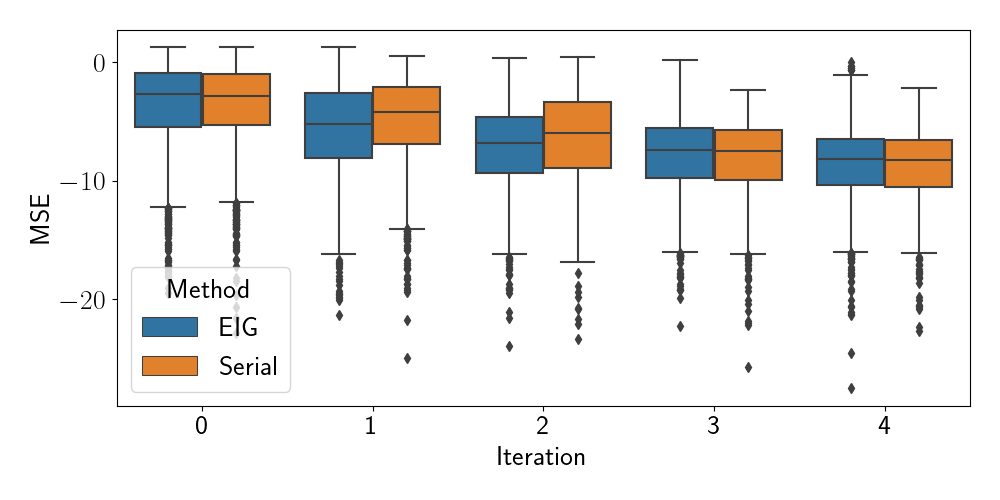

In [5]:
mse_eig_df = pd.melt(pd.DataFrame(np.log(mse_eig[0])))
mse_eig_df.columns = ["Iteration", "MSE"]
mse_eig_df["Method"] = "EIG"

mse_serial_df = pd.melt(pd.DataFrame(np.log(mse_serial[0])))
mse_serial_df.columns = ["Iteration", "MSE"]
mse_serial_df["Method"] = "Serial"

mse_df = pd.concat([mse_eig_df, mse_serial_df], axis=0)

plt.close()
plt.figure(figsize=(10, 5))

sns.boxplot(data=mse_df, x="Iteration", y="MSE", hue="Method")
# sns.boxplot(data=mse_serial_df, x="Iteration", y="MSE")
plt.tight_layout()
plt.show()

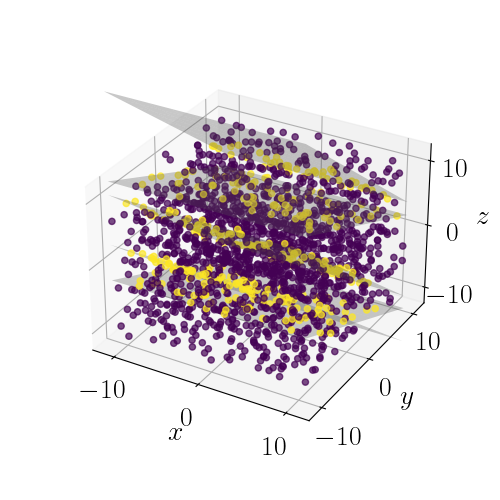

In [6]:



plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

plt.close()

fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

CLOSE_DIST = 2

# P = np.array([0, -100, 30, 20])
# P = np.array([1, -1, 0, 0])

# dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=np.isin(np.arange(len(coords)), observed_idx), alpha=0.7) #, s=5)

# xx, yy = np.meshgrid(range(np.max(coords[:, 0])), range(np.max(coords[:, 1])))
xx, yy = np.meshgrid(
    np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]), 10),
    np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), 10),
)

for P in chosen_designs[:5]: #[:6]:
# for P in designs_serial: #[:6]:
    if P[2] == 0:
        z = np.zeros(xx.shape)
    else:
        z = (P[0] * xx + P[1] * yy + P[3]) / -P[2]
    ax.plot_surface(xx, yy, z, color="gray", alpha=0.3)
    
# dists = compute_point_to_plane_dists(coords, P, signed=False)
# ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=dists < CLOSE_DIST, alpha=0.7) #, s=5)

ax.set_xlabel(r"$x$") #, rotation=90)
ax.set_ylabel(r"$y$") #, rotation=90)
ax.set_zlabel(r"$z$") #, rotation=90)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)



plt.show()

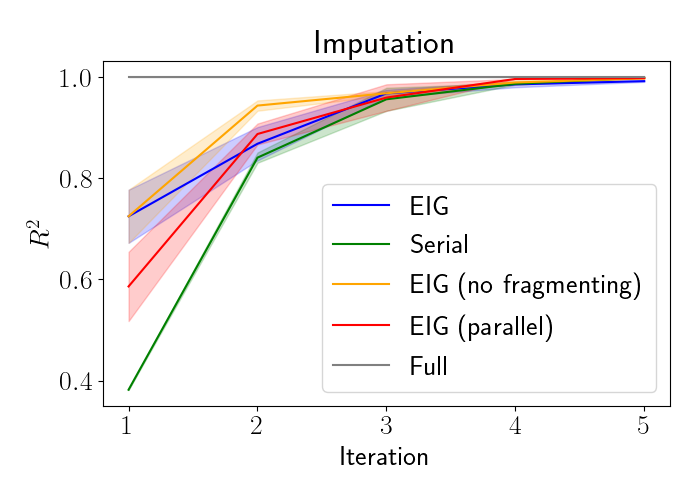

In [7]:

plt.figure(figsize=(7, 5))
# results_df = pd.DataFrame({"iter": np.arange(1, n_iters + 1), "r2": r2_scores})
# results_df_naive = pd.DataFrame({"iter": np.arange(1, n_iters + 1), "r2": r2_scores_naive})
results_df = pd.melt(pd.DataFrame(r2_eig))
results_df["variable"] += 1
results_df_naive = pd.melt(pd.DataFrame(r2_serial))
results_df_naive["variable"] += 1
results_df_nofragmenting = pd.melt(pd.DataFrame(r2_eig_no_fragmenting))
results_df_nofragmenting["variable"] += 1
results_df_parallel = pd.melt(pd.DataFrame(r2_eig_parallel))
results_df_parallel["variable"] += 1

results_df_full_atlas = pd.DataFrame({"iter": results_df.variable.values, "r2": np.tile(r2_full_atlas, num_experimental_iters)})


# sns.lineplot(data=results_df, x="iter", y="r2", label="Designed", color="blue")
# sns.lineplot(data=results_df_naive, x="iter", y="r2", label="Serial", color="green")
sns.lineplot(
    data=results_df,
    x="variable",
    y="value",
    label="EIG",
    color="blue",
)
sns.lineplot(
    data=results_df_naive,
    x="variable",
    y="value",
    label="Serial",
    color="green",
)
sns.lineplot(
    data=results_df_nofragmenting,
    x="variable",
    y="value",
    label="EIG (no fragmenting)",
    color="orange",
)
sns.lineplot(
    data=results_df_parallel,
    x="variable",
    y="value",
    label="EIG (parallel)",
    color="red",
)
sns.lineplot(
    data=results_df_full_atlas,
    x="iter",
    y="r2",
    label="Full",
    color="Gray",
)
plt.xticks(np.arange(1, num_experimental_iters + 1))
plt.xlabel("Iteration")
plt.ylabel(r"$R^2$")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Imputation")
plt.tight_layout()



plt.savefig("./out/simulated_prediction_experiment.png")
plt.show()

In [22]:
results_df

,variable,value
0,1,0.672162
1,1,0.777139
2,2,0.835094
3,2,0.900937
4,3,0.960214
5,3,0.974710
6,4,0.979694
7,4,0.990853
8,5,0.990334
9,5,0.993066


In [41]:
import pandas as pd
import numpy as np
from scipy import stats

def compute_confidence_interval(data):
    result = pd.DataFrame(columns=['Variable', 'Mean', 'Lower Bound', 'Upper Bound'])
    variables = data['variable'].unique()

    for variable in variables:
        values = data[data['variable'] == variable]['value']
        mean = np.mean(values)
        confidence_interval = stats.t.interval(0.95, len(values) - 1, loc=mean, scale=stats.sem(values))
        result = result.append({'Variable': variable, 'Mean': mean,
                                'Lower Bound': confidence_interval[0],
                                'Upper Bound': confidence_interval[1]}, ignore_index=True)

    return result



ci_df1 = compute_confidence_interval(results_df)
ci_df1["method"] = "EIG"
ci_df2 = compute_confidence_interval(results_df_naive)
ci_df2["method"] = "Serial"
ci_df3 = compute_confidence_interval(results_df_nofragmenting)
ci_df3["method"] = "EIG (no fragmenting)"
ci_df4 = compute_confidence_interval(results_df_parallel)
ci_df4["method"] = "EIG (parallel)"
results_df_full_atlas.columns = ["variable", "value"]
ci_df5 = compute_confidence_interval(results_df_full_atlas)
ci_df5["method"] = "Full"

ci_df = pd.concat([
    ci_df1,
    ci_df2,
    ci_df3,
    ci_df4,
    ci_df5,
])
ci_df.columns = ["Experimental iteration", "Mean", "CI lower bound", "CI upper bound", "Method"]
ci_df = ci_df[["Method", "Experimental iteration", "Mean", "CI lower bound", "CI upper bound"]]
ci_df["Experimental iteration"] = ci_df["Experimental iteration"].astype(int)
ci_df["Mean"] = pd.to_numeric(ci_df["Mean"]).round(2)
ci_df["CI lower bound"] = pd.to_numeric(ci_df["CI lower bound"]).round(2)
ci_df["CI upper bound"] = pd.to_numeric(ci_df["CI upper bound"]).round(2)
ci_df.to_csv("../../tmp/fig2_ci_df.csv", index=False)

<ipython-input-41-07dcef5f6c4c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Variable': variable, 'Mean': mean,
<ipython-input-41-07dcef5f6c4c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Variable': variable, 'Mean': mean,
<ipython-input-41-07dcef5f6c4c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Variable': variable, 'Mean': mean,
<ipython-input-41-07dcef5f6c4c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Variable': variable, 'Mean': mean,
<ipython-input-41-07dcef5f6c4c>:13: FutureWarning: The frame.append method i

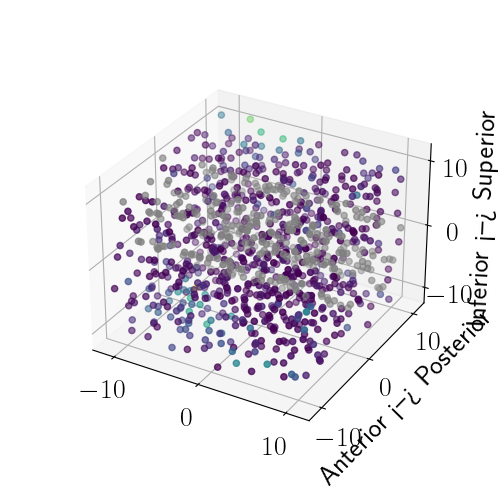

In [18]:
train_idx = observed_idx.copy()
unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx)
test_idx = unobserved_idx.copy()

## Fit GP, make predictions, and compute error
gpr = GPR(kernel=RBF(length_scale=length_scale) + WhiteKernel(noise_variance)) #, optimizer=None)
gpr.fit(coords[train_idx], outcome[train_idx])
preds = gpr.predict(coords[test_idx])

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[observed_idx][:, 0], coords[observed_idx][:, 1], coords[observed_idx][:, 2], color="gray")
ax.scatter3D(coords[test_idx][:, 0], coords[test_idx][:, 1], coords[test_idx][:, 2], c=(preds - outcome[test_idx]) ** 2)

ax.set_ylabel("Anterior <--> Posterior", rotation=90)
ax.set_zlabel("Inferior <--> Superior", rotation=90)

plt.show()

In [ ]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[observed_idx][:, 0], coords[observed_idx][:, 1], coords[observed_idx][:, 2], c=outcome[observed_idx])

ax.set_xlabel(r"$x$") #, rotation=90)
ax.set_ylabel(r"$y$") #, rotation=90)
ax.set_zlabel(r"$z$") #, rotation=90)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

ax.set_title("Simulated tissue")


plt.savefig("./out/simulated_tissue_3D.png")

plt.show()

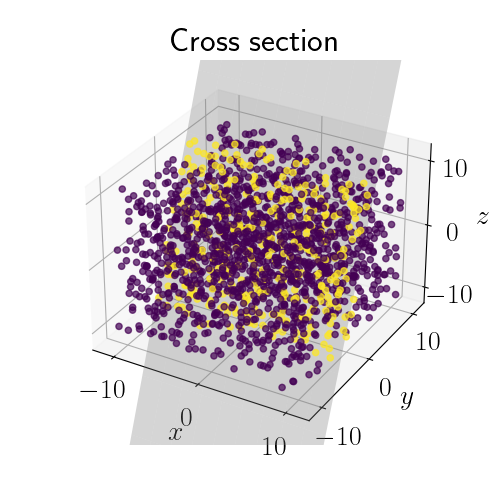

In [145]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

CLOSE_DIST = 2

P = np.array([0, -100, 30, 20])
# P = np.array([1, -1, 0, 0])

dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=dists < CLOSE_DIST, alpha=0.7) #, s=5)

# xx, yy = np.meshgrid(range(np.max(coords[:, 0])), range(np.max(coords[:, 1])))
xx, yy = np.meshgrid(
    np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]), 10),
    np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), 10),
)
z = (P[0] * xx + P[1] * yy + P[3]) / -P[2]
ax.plot_surface(xx, yy, z, color="gray", alpha=0.3)

ax.set_xlabel(r"$x$") #, rotation=90)
ax.set_ylabel(r"$y$") #, rotation=90)
ax.set_zlabel(r"$z$") #, rotation=90)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_title("Cross section")


plt.savefig("./out/simulated_example_slice.png")

plt.show()

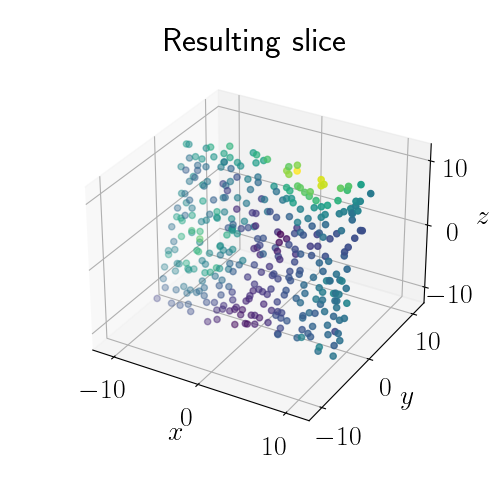

In [146]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

close_idx = np.where(dists < CLOSE_DIST)


normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T

projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
assert np.allclose(projected_point_dists, 0)

ax.scatter3D(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], c=outcome[close_idx])
# ax.scatter3D(coords[close_idx][:, 0], coords[close_idx][:, 1], coords[close_idx][:, 2])




ax.set_xlabel(r"$x$") #, rotation=90)
ax.set_ylabel(r"$y$") #, rotation=90)
ax.set_zlabel(r"$z$") #, rotation=90)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.set_title("Resulting slice")


plt.savefig("./out/simualated_example_resulting_slice.png")

plt.show()

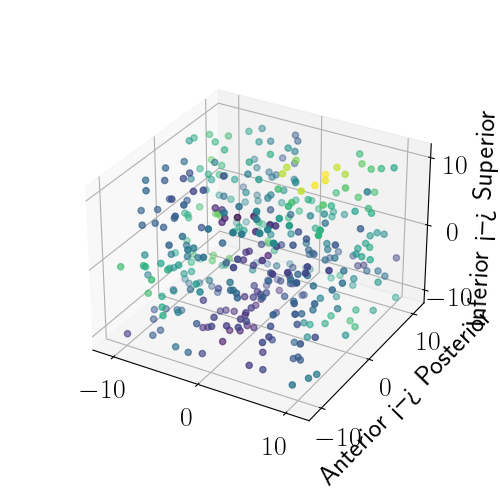

In [147]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[observed_idx_serial][:, 0], coords[observed_idx_serial][:, 1], coords[observed_idx_serial][:, 2], c=outcome[observed_idx_serial])

ax.set_ylabel("Anterior <--> Posterior", rotation=90)
ax.set_zlabel("Inferior <--> Superior", rotation=90)

plt.show()

In [ ]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')

ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=outcome)

ax.set_ylabel("Anterior <--> Posterior", rotation=90)
ax.set_zlabel("Inferior <--> Superior", rotation=90)

plt.show()

In [ ]:
num_experimental_iters